## Facebook Prophet model to forecast the 10-Year Treasury Constant Maturity Rate (DGS10)

In [63]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [64]:
# Prepare the data for Prophet
def prepare_prophet_data(data):
    prophet_data = data.reset_index().rename(columns={'Date': 'ds', 'Interest Rate': 'y'})
    return prophet_data

The data is split into training and test sets. Prophet requires the date (ds) and value (y) columns.

In [122]:
data = pd.read_csv('data.csv')
data.index.name = 'Date'

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter the DataFrame for data from 2012 onwards
filtered_data = data[data['Date'].dt.year >= 2012]

# Optionally, save the filtered data to a new CSV
filtered_data.to_csv('filtered_data.csv', index=False)

# Define the split point (e.g., use the last 20% of the data for testing)
split_point = int(len(filtered_data) * 0.8)

# Split the data
train_data = filtered_data.iloc[:split_point]
test_data = filtered_data.iloc[split_point:]

# Set the date as index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

In [145]:
train_prophet = prepare_prophet_data(train_data)
test_prophet = prepare_prophet_data(test_data)

# Initialize and fit the Prophet model
model = Prophet(
    changepoint_prior_scale=0.01,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
model.add_country_holidays(country_name='US')

# Add custom seasonality for economic cycles (assuming ~4 year cycles)
model.add_seasonality(name='economic_cycle', period=365.25*4, fourier_order=10)

model.fit(train_prophet)

22:28:51 - cmdstanpy - INFO - Chain [1] start processing
22:28:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

22:30:53 - cmdstanpy - INFO - Chain [1] start processing
22:30:54 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  1.22it/s]22:30:54 - cmdstanpy - INFO - Chain [1] start processing
22:30:54 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


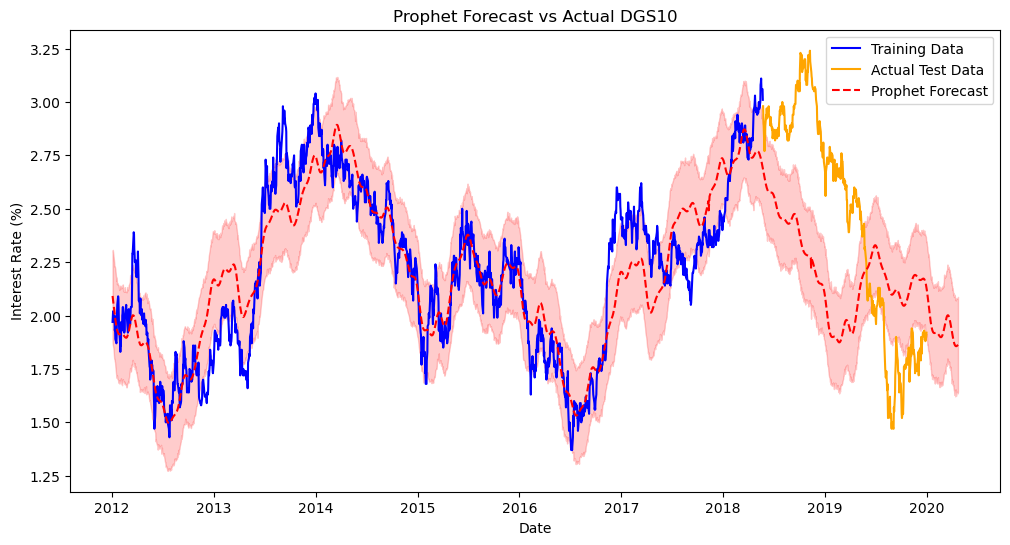

c:\Users\baubl\.conda\envs\dgs10\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\baubl\.conda\envs\dgs10\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\baubl\.conda\envs\dgs10\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain th

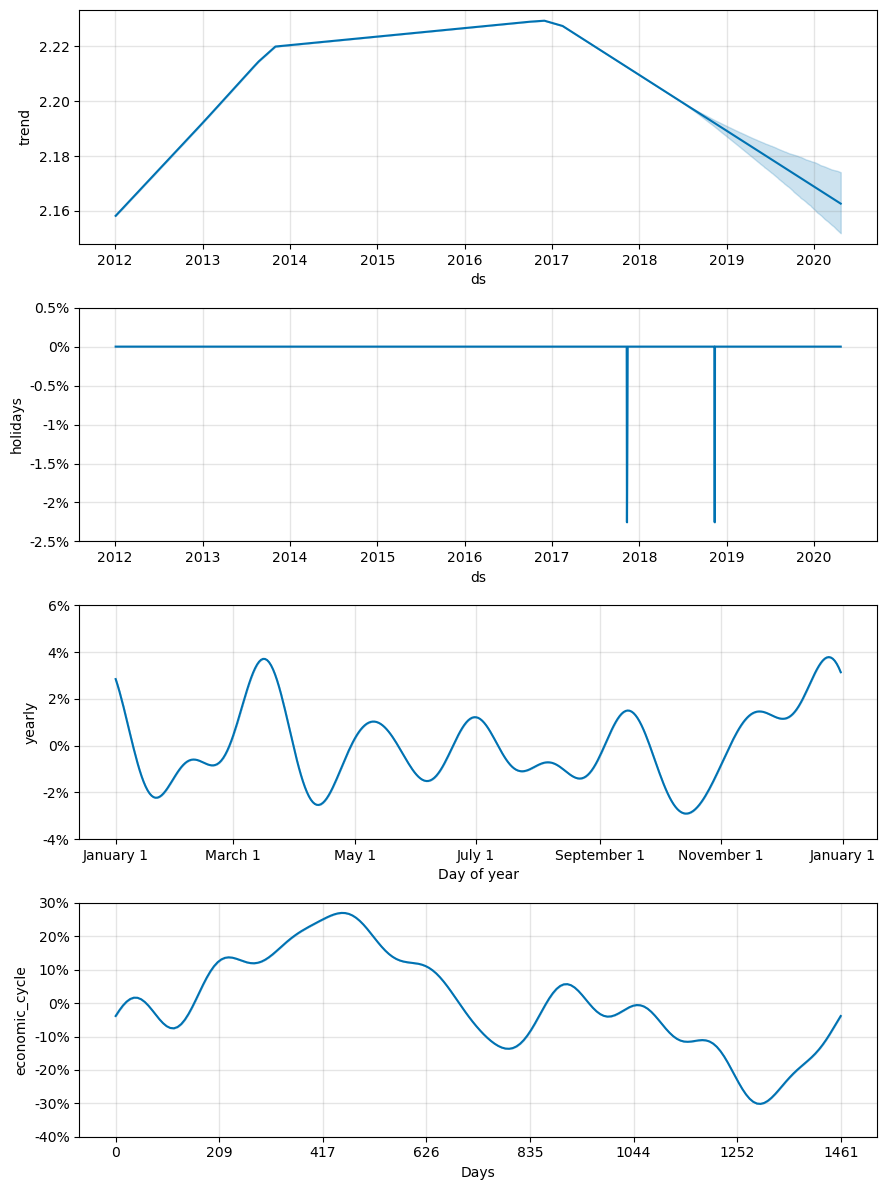

c:\Users\baubl\.conda\envs\dgs10\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\baubl\.conda\envs\dgs10\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


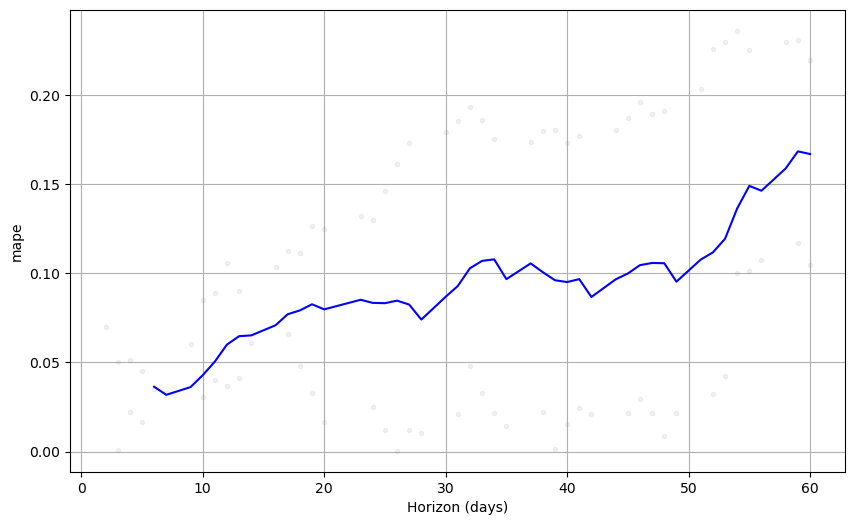

Mean Absolute Percentage Error (MAPE) on test set: 18.43%


In [149]:
# Cross-validation
cv_results = cross_validation(model, initial='1825 days', period='365 days', horizon='60 days')
cv_performance = performance_metrics(cv_results)

# Make future predictions
future_dates = model.make_future_dataframe(periods = 700)
forecast = model.predict(future_dates)

# Visualize results
def plot_forecast(train, test, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(train['ds'], train['y'], label='Training Data', color='blue')
    plt.plot(test['ds'], test['y'], label='Actual Test Data', color='orange')
    plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='red', linestyle='dashed')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)
    plt.title('Prophet Forecast vs Actual DGS10')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate (%)')
    plt.legend()
    plt.show()

plot_forecast(train_prophet, test_prophet, forecast)
model.plot_components(forecast)
plt.show()

# Plot cross-validation results
plot_cross_validation_metric(cv_results, metric='mape')
plt.show()

# Calculate and print MAPE for the test set
test_forecast = forecast.iloc[-len(test_prophet):]
mape = np.mean(np.abs((test_prophet['y'].values - test_forecast['yhat'].values) / test_prophet['y'].values)) * 100
print(f"Mean Absolute Percentage Error (MAPE) on test set: {mape:.2f}%")


#### Forcasting
Forcast graph compares the Prophet forecast with actual DGS10 values. The forecast (red dashed line) closely tracks the actual data (yellow for test data, blue for training data) with confidence intervals shaded in pink. The model does well in capturing the overall trend and seasonality, with some deviation towards the end (test period), reflecting the model’s sensitivity to sudden changes in the economy.

#### Components
**Trend**: The trend component shows a general decline in the 10-year interest rates from 2000 to around 2012, followed by stabilization and a slight increase towards the end of the forecast period. The confidence interval widens towards the future, indicating increasing uncertainty.
**Holidays**: This component does not have a major impact on the interest rate forecasts, showing small spikes in specific years, but these are minimal and do not greatly affect the overall forecast.
**Yearly**: The yearly component highlights seasonality in the data, showing cyclical behavior within each year, with peaks around mid-year (July) and troughs in the fall and winter months (October to December).
**Economic Cycle**: The model captures longer-term economic cycles, indicating rises and falls approximately every few years, reflecting underlying economic fluctuations.

#### Cross-Validation
The Mean Absolute Percentage Error (MAPE) over a prediction horizon (MAPE) increases slightly as the forecast horizon extends, indicating that the forecast accuracy decreases as the number of days out from the training set grows. However, the MAPE remains relatively low for the first several hundred days, indicating reasonable accuracy within shorter timeframes.

In [6]:
# Additional analysis: Trend changes
trend_changes = forecast[['ds', 'trend', 'trend_lower', 'trend_upper']]
trend_changes['trend_change'] = trend_changes['trend'].diff()
significant_changes = trend_changes[abs(trend_changes['trend_change']) > trend_changes['trend_change'].std() * 2]

print("\nSignificant trend changes:")
print(significant_changes[['ds', 'trend_change']])


Significant trend changes:
             ds  trend_change
579  2002-04-29     -0.014126
584  2002-05-06     -0.014126
589  2002-05-13     -0.014126
594  2002-05-20     -0.014126
599  2002-05-28     -0.018835
...         ...           ...
3434 2013-09-23      0.007271
3439 2013-09-30      0.007271
3444 2013-10-07      0.007271
3449 2013-10-15      0.009694
3453 2013-10-21      0.007271

[254 rows x 2 columns]


C:\Users\baubl\AppData\Local\Temp\ipykernel_19560\1156801623.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend_changes['trend_change'] = trend_changes['trend'].diff()
